In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from pandas_profiling import profile_report
from matplotlib import pyplot as plt
import seaborn as sns
import math
from random import randint
from sklearn.model_selection import train_test_split,RandomizedSearchCV

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import metrics as mt
import scorecardpy as sc
import warnings
warnings.simplefilter("ignore")


En primer lugar cargamos la base de datos

In [2]:
df=pd.read_csv("DataCredit.csv", sep=";")
df.head(2)

,Unnamed: 0,client,client_id,f_nac,edad,ingr_liquido,comuna,comuna_id,ciudad,ciudad_id,...,period_fabr,auto_tasacion,auto_tot_tas,num_auto,p_avaluo_total,marca_malo,dconsumo,lincred,dhipotecario,num_Inst
0,0,2711,1,08-11-1964,51,890869,LAS CONDES,119,SANTIAGO,44,...,2011.0,28477500.0,28477500.0,3.0,123350160.0,0.0,25506000.0,54258000.0,144142000.0,3.0
1,1,6711,33,16-03-1958,58,843262,SANTIAGO,271,SANTIAGO,44,...,2012.0,3300000.0,3300000.0,1.0,29729305.0,0.0,3746000.0,5837000.0,20796000.0,1.0


Luego revisamos las variables de la base y de que tipo son

In [3]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52394 entries, 0 to 52393
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      52394 non-null  int64  
 1   client          52394 non-null  int64  
 2   client_id       52394 non-null  int64  
 3   f_nac           52394 non-null  object 
 4   edad            52394 non-null  int64  
 5   ingr_liquido    52394 non-null  int64  
 6   comuna          52394 non-null  object 
 7   comuna_id       52394 non-null  int64  
 8   ciudad          52394 non-null  object 
 9   ciudad_id       52394 non-null  int64  
 10  region          52394 non-null  int64  
 11  gse             41989 non-null  object 
 12  gse_id          41989 non-null  float64
 13  prof            20621 non-null  object 
 14  prof_id         20621 non-null  float64
 15  genero          52394 non-null  int64  
 16  cond_civ        52394 non-null  int64  
 17  antig_client    52394 non-null 

(None, (52394, 31))

Verificamos que no hayan datos faltantes

In [4]:
df.isnull().sum()

Unnamed: 0            0
client                0
client_id             0
f_nac                 0
edad                  0
ingr_liquido          0
comuna                0
comuna_id             0
ciudad                0
ciudad_id             0
region                0
gse               10405
gse_id            10405
prof              31773
prof_id           31773
genero                0
cond_civ              0
antig_client          0
auto_marca        23190
auto                  0
auto_marca_id     23190
period_fabr       23190
auto_tasacion     23190
auto_tot_tas      23190
num_auto          23190
p_avaluo_total    20933
marca_malo           15
dconsumo             43
lincred              43
dhipotecario         43
num_Inst             43
dtype: int64

Se puede visualizar que hay varios parametros con datos faltantes que se repiten, por lo tanto, se podría asumir que hay alguna relación entre dichos parametros. 

Tanto *gse* como *gse_id* poseen 10 405 datos faltantes, ese es el primer caso a revisar.

Luego tanto *auto_marca* , *auto_marca_id* , *period_fabr* , *auto_tasacion* , *auto_tot_tas* , *num_auto* tienen 23 190 datos faltantes, este será el tercer caso a revisar.

Luego *prof* y *prof_id* tienen 31 773 datos faltantes, ese será el segundo caso a revisar. 


Luego *dconsumo* , *lincred* , *dhipotecario* y *num_Inst* poseen 43 datos faltantes este será el cuarto caso


Finalmente *p_avaluo_total* y *marca_malo* tienen 20 933 y 15 datos faltantes respectivamente, estos serán revisados particularmente.

In [5]:
df_gse = df[df["gse"].isnull()]
df_gse_id = df[df["gse_id"].isnull()]

if (df_gse["client_id"]==df_gse_id["client_id"]).all():
    print("Ambas variables tienen los mismos registros con datos faltanes")

Ambas variables tienen los mismos registros con datos faltanes


Se observa que, tanto las variables gse como gse_id poseen un porcentaje de valores faltantes de casi el 20% del total de registros, por lo que se toma la decisión de eliminar ambas variables, dado que tanto la imputación como la eliminación de registros, podrían provocar errores en el aprendizaje-testeo de los modelos a futuro

In [6]:
del df["gse"]
del df["gse_id"]

El segundo caso a analizar es el de los automoviles, al igual que en el anterior modelo se verificará si todos los datos pertenecen a las mismas personas. (*auto_marca* , *auto_marca_id* , *period_fabr* , *auto_tasacion* , *auto_tot_tas* , *num_auto*)


In [7]:
df_marca = df[df["auto_marca"].isnull()]
df_marca_id = df[df["auto_marca_id"].isnull()]
df_period_fabr = df[df["period_fabr"].isnull()]
df_tas = df[df["auto_tasacion"].isnull()]
df_tot_tas = df[df["auto_tot_tas"].isnull()]

if (df_marca["client_id"] == df_marca_id["client_id"]).all and (df_marca["client_id"] == df_period_fabr["client_id"]).all:
        if (df_marca["client_id"] == df_tas["client_id"]).all and (df_marca["client_id"] == df_tot_tas["client_id"]).all:
                print("Los datos faltantes son de los mismos registros")



Los datos faltantes son de los mismos registros


Al ser 23 190 datos faltantes que representan más del 44% del total de registros, se toma la decisión de no trabajar con las variables que hagan referencia a la tenencia de automovil, dado que la inputación de dichos valores, interviene de manera significativa en los resultados, por lo tanto se eliminaran todas las variables relacionadas a movilizacion

In [8]:
del df["auto_marca"]
del df["auto_marca_id"]
del df["period_fabr"]
del df["auto_tasacion"]
del df["num_auto"]
del df["auto_tot_tas"]

En el caso de las variables *prof* y *prof_id*, se tomá la decisión de eliminar ambas variables por el hecho de que los datos faltantes representan cerca de un 60% de todos los datos, por lo tanto, la manipulación de estos datos generaría un gran impacto negativo en la realidad de los datos.

In [9]:
del df["prof"]
del df["prof_id"]

El cuarto caso a analizar es el de las variables *dconsumo*, *lincred*, *dhipotecario* y *num_inst*, primero se debe analizar si todos los datos faltantes provienen de los mismos clientes

In [10]:
df_lincred = df[df["lincred"].isnull()]
df_dconsumo = df[df["dconsumo"].isnull()]
df_dhipotecario = df[df["dhipotecario"].isnull()]
df_num_inst = df[df["num_Inst"].isnull()]

if (df_lincred["client_id"]==df_dconsumo["client_id"]).all and (df_dhipotecario["client_id"]==df_num_inst["client_id"]).all and (df_lincred["client_id"]==df_dhipotecario["client_id"]).all:
    print("Los datos faltantes provienen de los mismos clientes")

Los datos faltantes provienen de los mismos clientes


Luego de analizar los datos faltantes de dichas variables, se infiere que son personas, las cuales no tienen un historial crediticio, ya que, no poseen registros de creditos, las propiedades que poseen son de bajo valor, al igual que los autos, por lo tanto, no son objeto de estudio, ya que no hacen uso de créditos, por lo tanto, no nos interesa saber si son buenos o malos clientes. Por lo tanto se eliminaran aquellos registros.

In [11]:
df = df.dropna(subset = ["lincred"])

En el caso de la variable *p_avaluo_total* se asignara un valor 0 a el avaluo de su propiedad, infiriendo que no poseen una.

In [12]:
df["p_avaluo_total"].fillna(0, inplace=True)

En el caso de la variable *marca_malo* los datos faltantes se eliminaran, debido a que no poseemos el modelo con el cual se clasifico a los clientes como buenos o malos, por lo tanto, se podría clasificar erroneamente.

In [13]:
df = df.dropna(subset=["marca_malo"])

In [14]:
df.duplicated().sum(), df.isnull().sum()

(0,
 Unnamed: 0        0
 client            0
 client_id         0
 f_nac             0
 edad              0
 ingr_liquido      0
 comuna            0
 comuna_id         0
 ciudad            0
 ciudad_id         0
 region            0
 genero            0
 cond_civ          0
 antig_client      0
 auto              0
 p_avaluo_total    0
 marca_malo        0
 dconsumo          0
 lincred           0
 dhipotecario      0
 num_Inst          0
 dtype: int64)

Luego de aplicar todos estos cambios a la base de datos, se obtiene una base limpia, sin datos nulos, ni datos duplicados, ahora se procederá a hacer un analisis por variable.

Eliminaremos tanto las variables "client", como "client_id", ya que ambas son identificadores que son irrelevantes en la toma de decisiones, dado que no nos entregan mayor información acerca de la conducta del cliente, generalmente son utilizadas por el banco para tener un "orden" de los datos..

In [15]:
del df["client"]
del df["client_id"]

Elimiminaremos tambien la fecha de nacimiento, ya que, entrega la misma información que la edad del cliente

In [16]:
del df["f_nac"]

In [17]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52337 entries, 0 to 52393
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      52337 non-null  int64  
 1   edad            52337 non-null  int64  
 2   ingr_liquido    52337 non-null  int64  
 3   comuna          52337 non-null  object 
 4   comuna_id       52337 non-null  int64  
 5   ciudad          52337 non-null  object 
 6   ciudad_id       52337 non-null  int64  
 7   region          52337 non-null  int64  
 8   genero          52337 non-null  int64  
 9   cond_civ        52337 non-null  int64  
 10  antig_client    52337 non-null  int64  
 11  auto            52337 non-null  int64  
 12  p_avaluo_total  52337 non-null  float64
 13  marca_malo      52337 non-null  float64
 14  dconsumo        52337 non-null  float64
 15  lincred         52337 non-null  float64
 16  dhipotecario    52337 non-null  float64
 17  num_Inst        52337 non-null 

(None, (52337, 18))

Vamos a ver otras variables correlacionadas

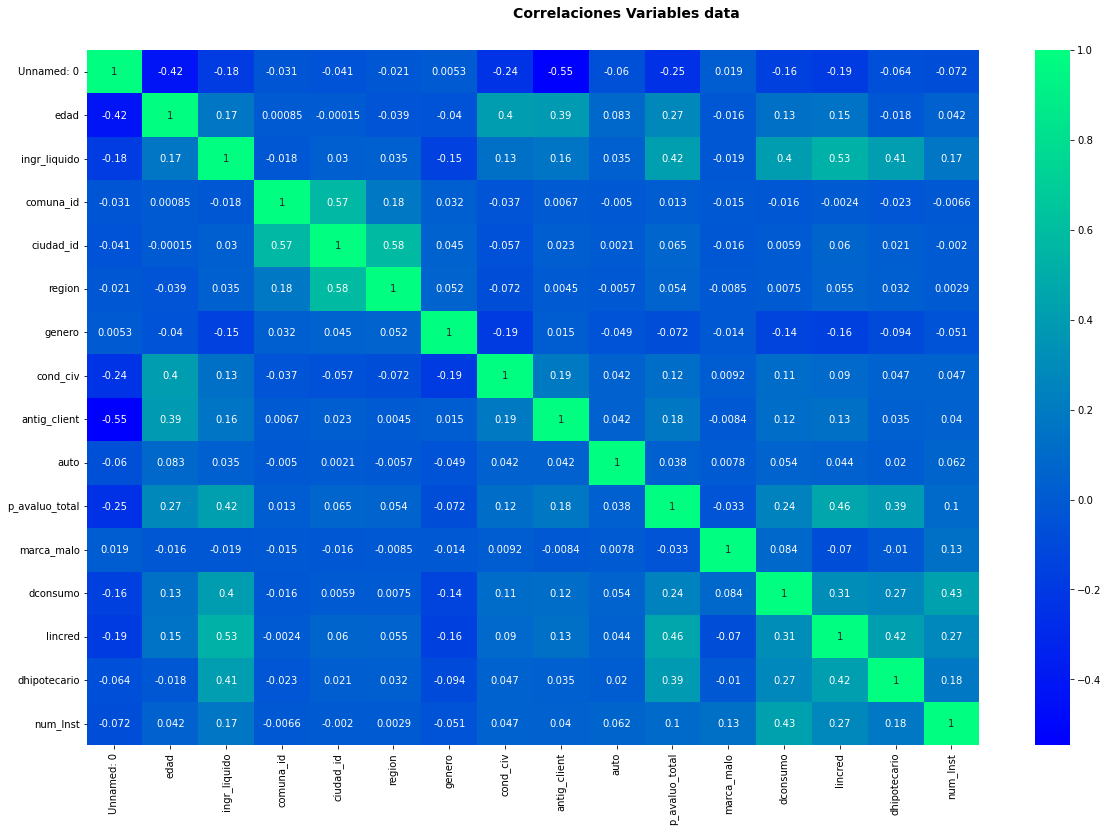

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20,12))
corr = df.corr()
sns.heatmap(corr,ax = ax, cmap='winter',annot=True)
fig.subplots_adjust(top = 0.93)
fig.suptitle('Correlaciones Variables data', fontsize=14,fontweight='bold')
plt.show()

Se observa una alta correlación entre las variables *ciudad_id*, *comuna_id* y *region* lo que es esperable, dado que la comuna implicitamente entrega información de la ciudad y la región, por lo tanto, eliminaremos tanto *ciudad_id* como *comuna_id*, dado a que la cantidad de opciones que tiene la variable crece exponencialmente, en otras palabras, la región solo posee 15 opciones en cambio la ciudad y la comuna, más de 100 lo que sería absurdo a la hora de hacer analisis, por ejemplo en arboles de decision

In [19]:
del df["ciudad_id"]
del df["comuna_id"]

Finalmente se elimina la variable *Unnamed* debido a la falta de información de lo que señala esta variable

In [20]:
del df["Unnamed: 0"]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52337 entries, 0 to 52393
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   edad            52337 non-null  int64  
 1   ingr_liquido    52337 non-null  int64  
 2   comuna          52337 non-null  object 
 3   ciudad          52337 non-null  object 
 4   region          52337 non-null  int64  
 5   genero          52337 non-null  int64  
 6   cond_civ        52337 non-null  int64  
 7   antig_client    52337 non-null  int64  
 8   auto            52337 non-null  int64  
 9   p_avaluo_total  52337 non-null  float64
 10  marca_malo      52337 non-null  float64
 11  dconsumo        52337 non-null  float64
 12  lincred         52337 non-null  float64
 13  dhipotecario    52337 non-null  float64
 14  num_Inst        52337 non-null  float64
dtypes: float64(6), int64(7), object(2)
memory usage: 6.4+ MB


In [22]:
len(df["ciudad"].value_counts())+len(df["comuna"].value_counts())

351

Ahora en el caso de comuna y ciudad, nos percatamos de que son variables de tipo object-categoricas pero que son nominales, por lo tanto, se debería aplicar un método denominado One-Hot Encoding, pero esto implicaría agregar 351 variables, por lo tanto, se toma la decisión de eliminar dichas variables. 

In [23]:
del df["ciudad"]
del df["comuna"]

In [24]:
df.head(2)

,edad,ingr_liquido,region,genero,cond_civ,antig_client,auto,p_avaluo_total,marca_malo,dconsumo,lincred,dhipotecario,num_Inst
0,51,890869,13,1,3,8,1,123350160.0,0.0,25506000.0,54258000.0,144142000.0,3.0
1,58,843262,13,2,1,5,1,29729305.0,0.0,3746000.0,5837000.0,20796000.0,1.0


## Analisis descriptivo de las variables

In [25]:
#Definimos una funcion que nos entregue un analisis descriptivo de cada variable (obviamente numerica)
def analisis(D):
    minimo = np.min(D)
    maximo = np.max(D)
    desviacion_estandar = np.std(D)
    cuartil_1 = np.quantile(D,0.25)
    cuartil_2 = np.quantile(D,0.5)
    cuartil_3 = np.quantile(D, 0.75)
    promedio = np.mean(D)
    return minimo, maximo, desviacion_estandar, promedio, cuartil_1, cuartil_2, cuartil_3


In [26]:
minimo, maximo, desviacion_estandar, promedio, cuartil_1, cuartil_2, cuartil_3 = analisis(df["edad"])
print(f"Edad:\n Minimo: {minimo}; Máximo: {maximo}; Desviación Estandar: {desviacion_estandar}; Promedio: {promedio}; Q1: {cuartil_1}; Q2: {cuartil_2}; Q3:{cuartil_3}")

minimo, maximo, desviacion_estandar, promedio, cuartil_1, cuartil_2, cuartil_3 = analisis(df["ingr_liquido"])
print(f"Ingreso Líquido:\n Mínimo: {minimo}; Máximo: {maximo}; Desviación Estandar: {desviacion_estandar}; Promedio: {promedio}; Q1: {cuartil_1}; Q2: {cuartil_2}; Q3:{cuartil_3}")

minimo, maximo, desviacion_estandar, promedio, cuartil_1, cuartil_2, cuartil_3 = analisis(df["cond_civ"])
print(f"Cond Civil:\n Mínimo: {minimo}; Máximo: {maximo}; Desviación Estandar: {desviacion_estandar}; Promedio: {promedio}; Q1: {cuartil_1}; Q2: {cuartil_2}; Q3:{cuartil_3}")

minimo, maximo, desviacion_estandar, promedio, cuartil_1, cuartil_2, cuartil_3 = analisis(df["antig_client"])
print(f"Antiguedad:\n Mínimo: {minimo}; Máximo: {maximo}; Desviación Estandar: {desviacion_estandar}; Promedio: {promedio}; Q1: {cuartil_1}; Q2: {cuartil_2}; Q3:{cuartil_3}")

minimo, maximo, desviacion_estandar, promedio, cuartil_1, cuartil_2, cuartil_3 = analisis(df["p_avaluo_total"])
print(f"Avaluo Propiedad:\n Mínimo: {minimo}; Máximo: {maximo}; Desviación Estandar: {desviacion_estandar}; Promedio: {promedio}; Q1: {cuartil_1}; Q2: {cuartil_2}; Q3:{cuartil_3}")

minimo, maximo, desviacion_estandar, promedio, cuartil_1, cuartil_2, cuartil_3 = analisis(df["dconsumo"])
print(f"Deuda consumo:\n Mínimo: {minimo}; Máximo: {maximo}; Desviación Estandar: {desviacion_estandar}; Promedio: {promedio}; Q1: {cuartil_1}; Q2: {cuartil_2}; Q3:{cuartil_3}")

minimo, maximo, desviacion_estandar, promedio, cuartil_1, cuartil_2, cuartil_3 = analisis(df["lincred"])
print(f"Linea Credito:\n Mínimo: {minimo}; Máximo: {maximo}; Desviación Estandar: {desviacion_estandar}; Promedio: {promedio}; Q1: {cuartil_1}; Q2: {cuartil_2}; Q3:{cuartil_3}")

minimo, maximo, desviacion_estandar, promedio, cuartil_1, cuartil_2, cuartil_3 = analisis(df["dhipotecario"])
print(f"Deuda Hipoteca:\n Mínimo: {minimo}; Máximo: {maximo}; Desviación Estandar: {desviacion_estandar}; Promedio: {promedio}; Q1: {cuartil_1}; Q2: {cuartil_2}; Q3:{cuartil_3}")

minimo, maximo, desviacion_estandar, promedio, cuartil_1, cuartil_2, cuartil_3 = analisis(df["auto"])
print(f"Auto:\n Mínimo: {minimo}; Máximo: {maximo}; Desviación Estandar: {desviacion_estandar}; Promedio: {promedio}; Q1: {cuartil_1}; Q2: {cuartil_2}; Q3:{cuartil_3}")


Edad:
 Minimo: 23; Máximo: 66; Desviación Estandar: 8.802746251760976; Promedio: 42.650973498672066; Q1: 36.0; Q2: 41.0; Q3:48.0
Ingreso Líquido:
 Mínimo: 251691; Máximo: 81077808; Desviación Estandar: 1684318.6985907892; Promedio: 1828985.5945124864; Q1: 881476.0; Q2: 1384449.0; Q3:2271884.0
Cond Civil:
 Mínimo: 1; Máximo: 3; Desviación Estandar: 0.7680754448694173; Promedio: 1.7176185108049755; Q1: 1.0; Q2: 2.0; Q3:2.0
Antiguedad:
 Mínimo: 0; Máximo: 25; Desviación Estandar: 3.7247510768386936; Promedio: 2.344918508894281; Q1: 0.0; Q2: 0.0; Q3:4.0
Avaluo Propiedad:
 Mínimo: 0.0; Máximo: 950551028.0; Desviación Estandar: 48485751.0476414; Promedio: 29373624.274108183; Q1: 0.0; Q2: 15798038.0; Q3:39190263.0
Deuda consumo:
 Mínimo: 0.0; Máximo: 501724000.0; Desviación Estandar: 20152847.883481815; Promedio: 12892207.558706079; Q1: 1504000.0; Q2: 6135000.0; Q3:15983000.0
Linea Credito:
 Mínimo: 0.0; Máximo: 437439000.0; Desviación Estandar: 18759231.008408763; Promedio: 15943977.18631178

## Limpieza de outliers

#### Box-Plots para identificar datos outliers

<AxesSubplot:ylabel='dhipotecario'>

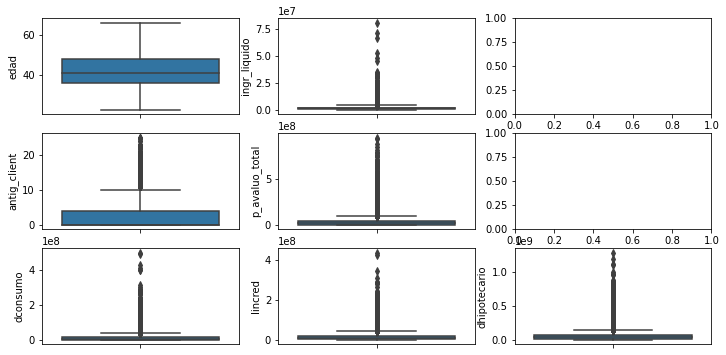

In [27]:
fig, axs = plt.subplots(3, 3, figsize=(12, 6))
sns.boxplot(y="edad", data=df, ax=axs[0,0])
sns.boxplot(y="ingr_liquido", data=df, ax=axs[0,1])
sns.boxplot(y="antig_client", data=df, ax=axs[1,0])
sns.boxplot(y="p_avaluo_total", data=df, ax=axs[1,1])
sns.boxplot(y="dconsumo", data=df, ax=axs[2,0])
sns.boxplot(y="lincred", data=df, ax=axs[2,1])
sns.boxplot(y="dhipotecario", data=df, ax=axs[2,2])

In [28]:
df_antiguo=df
df_antiguo.shape

(52337, 13)

Como se puede ver la unica varible que no presenta outliers es edad,por ende vamos calcular proceder a hacer una limpieza de outliers de las demás variables utilizando rangos intercuartiles.

In [29]:
#Definimos una función que nos devuelve los límites superiores e inferiores
def limpieza_outliers(D):
    #Cálculo de cuartiles
    Q1 = D.quantile(0.25) #Cuartil 1
    Q3 = D.quantile(0.75) #Cuartil 2
    #Rango inter-cuartil
    IQR = Q3-Q1
    #Limite superior e inferior
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    #Devolvemos el limite superior e inferior para luego ingresarlo a la BBDD
    return lower_limit, upper_limit

In [30]:
df.shape

(52337, 13)

In [31]:
#Limpieza de ouliers variable ingr_liquido
lower_limit, upper_limit = limpieza_outliers(df["ingr_liquido"])
df = df[(df["ingr_liquido"]>lower_limit) & (df["ingr_liquido"]<upper_limit)]
df.shape

(49513, 13)

In [32]:
#Limpieza de outliers para la variable antig_client
lower_limit, upper_limit = limpieza_outliers(df["antig_client"])
df = df[(df["antig_client"]>lower_limit) & (df["antig_client"]<upper_limit)]
df.shape

(46383, 13)

In [33]:
#Limpieza de outliers para la variable p_avaluo_total
lower_limit, upper_limit = limpieza_outliers(df["p_avaluo_total"])
df = df[(df["p_avaluo_total"]>lower_limit) & (df["p_avaluo_total"]<upper_limit)]
df.shape


(43867, 13)

In [34]:
#Limpieza de outliers para la variable dconsumo
lower_limit, upper_limit = limpieza_outliers(df["dconsumo"])
df = df[(df["dconsumo"]>lower_limit) & (df["dconsumo"]<upper_limit)]
df.shape

(40824, 13)

In [35]:
#Limpieza de outliers para la variable lincred
lower_limit, upper_limit = limpieza_outliers(df["lincred"])
df = df[(df["lincred"]>lower_limit) & (df["lincred"]<upper_limit)]
df.shape

(38494, 13)

In [36]:
#Limpieza de outliers para la variable dhipotecario
lower_limit, upper_limit = limpieza_outliers(df["dhipotecario"])
df = df[(df["dhipotecario"]>lower_limit) & (df["dhipotecario"]<upper_limit)]
df.shape

(36854, 13)

<AxesSubplot:ylabel='dhipotecario'>

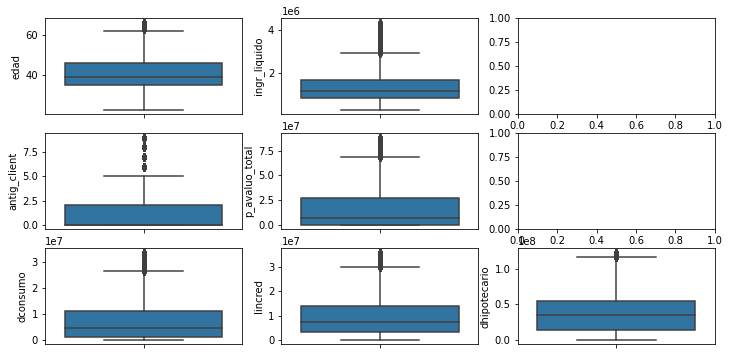

In [37]:
fig, axs = plt.subplots(3, 3, figsize=(12, 6))
sns.boxplot(y="edad", data=df, ax=axs[0,0])
sns.boxplot(y="ingr_liquido", data=df, ax=axs[0,1])
sns.boxplot(y="antig_client", data=df, ax=axs[1,0])
sns.boxplot(y="p_avaluo_total", data=df, ax=axs[1,1])
sns.boxplot(y="dconsumo", data=df, ax=axs[2,0])
sns.boxplot(y="lincred", data=df, ax=axs[2,1])
sns.boxplot(y="dhipotecario", data=df, ax=axs[2,2])

Como se observa, disminuyó considerablemente la presencia de outliers, sin eliminar datos que nos desfavorecen.

In [38]:
df_antiguo.shape[0], df.shape[0]

(52337, 36854)

La base paso de tener 52 337 datos a 36 693 datos una disminución de casi el 30% de datos, los cuales estaban claramente fuera de lo normal, como se logra apreciar en los gráficos no se hizo una eliminación por completa de datos atípicos (que nos desfavorecen), ya que estos registros pertenecen al mundo real de datos a modelar.

# Analisis bivariante

In [39]:
#Creación de variables
# Ratio de endeudamiento
df["Ratio endeudamiento"]= df["dconsumo"]/df["ingr_liquido"]
#Ratio de línea de crédito
df["Ratio Linea de crédito"]=df["lincred"]/(df["lincred"]+df["dconsumo"])
#Proxy Patrimonio
df["Patrimonio"]=df["p_avaluo_total"]+df["ingr_liquido"]+df["lincred"]-(df["dconsumo"]+df["dhipotecario"])


In [40]:
df.isnull().sum()

edad                       0
ingr_liquido               0
region                     0
genero                     0
cond_civ                   0
antig_client               0
auto                       0
p_avaluo_total             0
marca_malo                 0
dconsumo                   0
lincred                    0
dhipotecario               0
num_Inst                   0
Ratio endeudamiento        0
Ratio Linea de crédito    29
Patrimonio                 0
dtype: int64

Se observan 29 datos atípicos en la variable ratio línea de crédito, esto puede ser resultado de una division por 0, vamos a revisar si son clientes con *marca_malo* = 1, si no es el caso, se eliminaran.

In [41]:
orlc = df[df["Ratio Linea de crédito"].isnull()]
orlc["marca_malo"].value_counts()

0.0    28
1.0     1
Name: marca_malo, dtype: int64

Como se observa, son mayoritariamente clientes buenos, por lo tanto, no afectarán de manera considerable el modelo si se eliminan, por lo tanto, los vamos a eliminar

In [42]:
df = df.dropna(subset=["Ratio Linea de crédito"])

# Normalización de los datos

In [43]:
from sklearn.preprocessing import MinMaxScaler

#Primero creamos un dataset que no contenga la variable objetivo
df1 = df.copy() 
y = df["marca_malo"] #En esta variable guardamos la variable objetivo


scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df1) 
df1.loc[:,:] = scaled_values
df1.head()


,edad,ingr_liquido,region,genero,cond_civ,antig_client,auto,p_avaluo_total,marca_malo,dconsumo,lincred,dhipotecario,num_Inst,Ratio endeudamiento,Ratio Linea de crédito,Patrimonio
1,0.813953,0.144128,0.857143,1.0,0.0,0.555556,1.0,0.336909,0.0,0.112105,0.162351,0.169887,0.125,0.050265,0.609099,0.597196
2,0.465116,0.119460,1.000000,1.0,0.0,0.777778,0.0,0.000000,1.0,0.605985,0.010458,0.109108,0.250,0.308783,0.018230,0.426453
4,0.255814,0.161258,0.857143,1.0,0.5,0.333333,1.0,0.214360,0.0,0.513332,0.194949,0.368831,0.250,0.212450,0.290084,0.414993
6,0.744186,0.342598,0.857143,0.0,1.0,0.666667,0.0,0.024052,0.0,0.000389,0.592579,0.170205,0.125,0.000089,0.999390,0.567823
7,0.418605,0.658363,0.857143,0.0,1.0,0.222222,0.0,0.212541,0.0,0.310070,0.002781,0.257158,0.125,0.039688,0.009559,0.474402


# Information Value (IV)

Information Value, es un párametro que nos entrega la capacidad predictiva de cada variable de un dataset, en donde se definen parametros para identificar que tan buena es, por ejemplo menor a 0.02 es inútil para el modelo en cambio, un valor sobre 0.5 indica un gran poder predictivo.

Por términos de que en este curso no se profundizó en los términos de Information Value y Weight of evidence, se hizo uso de apoyo virtual para el cálculo de este párametro, la infromación fue sacada principalmente del siguiente foro:

http://shichen.name/scorecard/


In [44]:
# sc.iv(df1, y="marca_malo")

Como se observa, las variables *gse_id*, *genero*, *cond_civ*, *antig_cliente* y *auto* tienen un information value menor a 0.02 lo que nos indica que son variables que no son utiles para la predicción de la variable objetivo, en este caso, si el cliente es bueno o malo, por lo tanto, se toma la decisión de eliminar dichas variables.

In [45]:
del df1["genero"]
del df1["cond_civ"]
del df1["antig_client"]
del df1["auto"]
del df1["Patrimonio"]

Analogamente, las variables *p_avaluo_total*, *dconsumo* y *dhipotecario* tienen un nivel sospechosamente alto, lo que podría generar problemas de calibración y de confiabilidad en el modelo, por lo tanto, de igual manera las eliminaremos.

In [46]:
del df1["p_avaluo_total"]
del df1["dconsumo"]
del df1["dhipotecario"]

## Correlación de datos

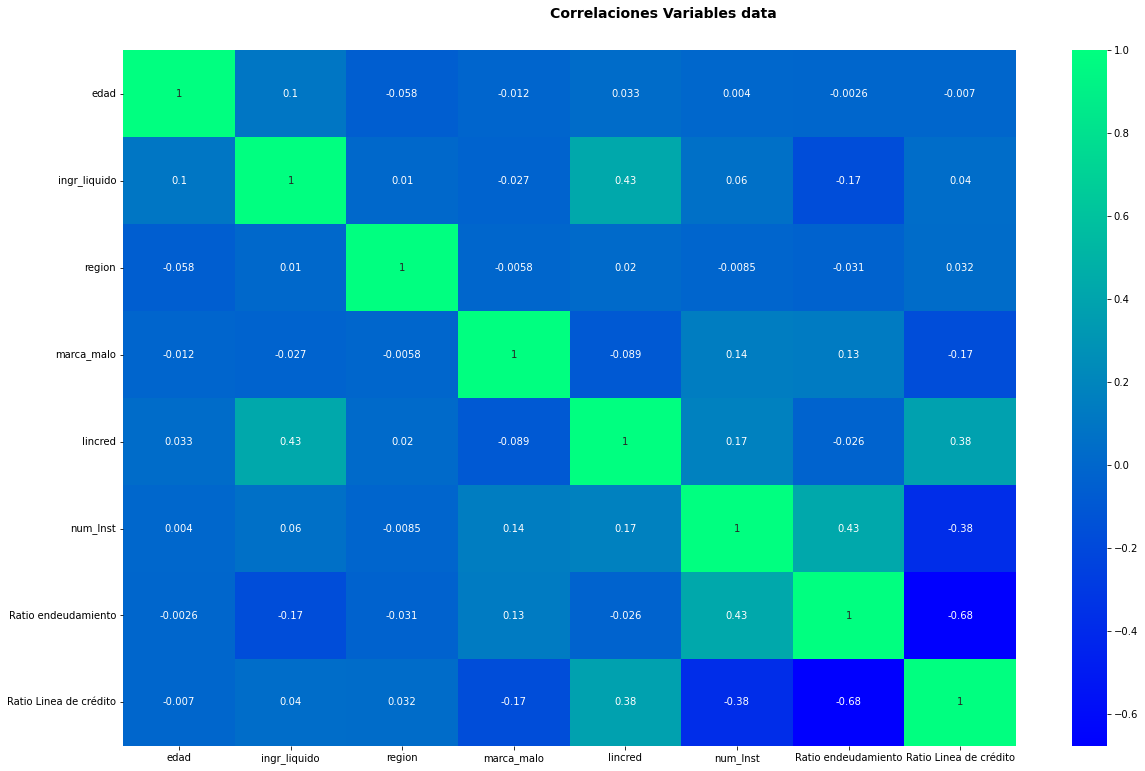

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(20,12))
corr = df1.corr()
sns.heatmap(corr,ax = ax, cmap='winter',annot=True)
fig.subplots_adjust(top = 0.93)
fig.suptitle('Correlaciones Variables data', fontsize=14,fontweight='bold')
plt.show()

Finalmente, se obtiene una base de datos sin datos claramente atípicos, con datos no "tan" correlacionados (<0.7), estandarizados, sin datos faltantes ni duplicados.

# Desbalanceo de clases

In [48]:
df["marca_malo"].value_counts()

0.0    34914
1.0     1911
Name: marca_malo, dtype: int64

<AxesSubplot:xlabel='marca_malo', ylabel='Count'>

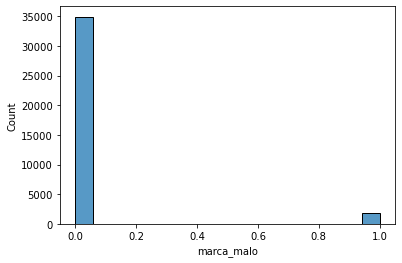

In [49]:
sns.histplot(data=df, x ="marca_malo")

Se aprecia una clara diferencia en la proporción de clases en primer lugar, la clase 0 posee cerca de un 95% de todos los registros, en cambio, la clase 1, tiene cerca de un 5% de registros, lo que generaría sesgamiento en los modelos a la hora de entrenarlos, por lo tanto se deben utilizar métodos como el oversampling o el undersampling para evitar el sesgo y predicciones erronéas.

# Creación de datasets de Oversampling y Undersampling

### Partición de datos en datos de entrenamiento y datos de testeo

In [50]:
#En primer lugar, eliminamos la variable objetivo del dataset de entrenamiento, recordar que en la variable "y" está la clase a predecir
del df1["marca_malo"]

Se utilizara un 70% de los datos para entrenar los modelos y el 30% restante será para testear el modelo

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df1,y, test_size = 0.30, random_state = 42, stratify = y)

## Oversampling

Debido a que no se le dio un gran enfasis a este tópico, se hizo uso de contenido virtual para la realización del método, la cual fue sustraida del siguiente foro:
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [52]:
print("Antes del Oversampling el conteo de la clase '1' es: {}".format(sum(y_train == 1))) 
print("Antes del Oversampling el conteo de la clase '0' es: {} \n".format(sum(y_train == 0))) 

sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel()) 
  
print('Luego del Oversampling la dimension de X_train: {}'.format(X_train_res.shape)) 
print('Luego del Oversampling la dimension de Y_train: {} \n'.format(y_train_res.shape)) 
  
print("Luego del Oversampling el conteo de la clase '1' es: {}".format(sum(y_train_res == 1))) 
print("Luego del Oversampling el conteo de la clase '0' es: {}".format(sum(y_train_res == 0))) 

Antes del Oversampling el conteo de la clase '1' es: 1338
Antes del Oversampling el conteo de la clase '0' es: 24439 

Luego del Oversampling la dimension de X_train: (48878, 7)
Luego del Oversampling la dimension de Y_train: (48878,) 

Luego del Oversampling el conteo de la clase '1' es: 24439
Luego del Oversampling el conteo de la clase '0' es: 24439


## Undersampling

Se aplicaran dos métodos de UnderdSampling los cuales son aleatorio y NearMiss

## Undersampling aleatorio

Debido a que no se le dio un gran enfasis a este tópico, se hizo uso de contenido virtual para la realización del método, la cual fue sustraida del siguiente foro:
https://medium.com/grabngoinfo/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037

In [53]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)


print("Antes del Undersampling Aleatorio el conteo de la clase '1' es: {}".format(sum(y_train == 1))) 
print("Antes del Undersampling Aleatorio el conteo de la clase '0' es: {} \n".format(sum(y_train == 0))) 
  
print('Luego del Undersampling Aleatorio la dimension de X_train: {}'.format(X_train_rus.shape)) 
print('Luego del Undersampling Aleatorio la dimension de Y_train: {} \n'.format(y_train_rus.shape)) 
  
print("Luego del Undersampling Aleatorio el conteo de la clase '1' es: {}".format(sum(y_train_rus == 1))) 
print("Luego del Undersampling Aleatorio el conteo de la clase '0' es: {}".format(sum(y_train_rus == 0))) 

Antes del Undersampling Aleatorio el conteo de la clase '1' es: 1338
Antes del Undersampling Aleatorio el conteo de la clase '0' es: 24439 

Luego del Undersampling Aleatorio la dimension de X_train: (2676, 7)
Luego del Undersampling Aleatorio la dimension de Y_train: (2676,) 

Luego del Undersampling Aleatorio el conteo de la clase '1' es: 1338
Luego del Undersampling Aleatorio el conteo de la clase '0' es: 1338


## Undersampling NearMiss

In [54]:
nearmiss = NearMiss(version=3)
X_train_nearmiss, y_train_nearmiss= nearmiss.fit_resample(X_train, y_train)


print("Antes del Undersampling NearMiss el conteo de la clase '1' es: {}".format(sum(y_train == 1))) 
print("Antes del Undersampling NearMiss el conteo de la clase '0' es: {} \n".format(sum(y_train == 0))) 
  
print('Luego del Undersampling NearMiss la dimension de X_train: {}'.format(X_train_nearmiss.shape)) 
print('Luego del Undersampling NearMiss la dimension de Y_train: {} \n'.format(y_train_nearmiss.shape)) 
  
print("Luego del Undersampling NearMiss el conteo de la clase '1' es: {}".format(sum(y_train_nearmiss == 1))) 
print("Luego del Undersampling NearMiss el conteo de la clase '0' es: {}".format(sum(y_train_nearmiss == 0))) 

Antes del Undersampling NearMiss el conteo de la clase '1' es: 1338
Antes del Undersampling NearMiss el conteo de la clase '0' es: 24439 

Luego del Undersampling NearMiss la dimension de X_train: (2676, 7)
Luego del Undersampling NearMiss la dimension de Y_train: (2676,) 

Luego del Undersampling NearMiss el conteo de la clase '1' es: 1338
Luego del Undersampling NearMiss el conteo de la clase '0' es: 1338


# Modelos Predictivos

# Regresion logistica

El primer modelo a entrenar será regresión logistica, del cual obtendremos el mejor set de datos para entrenar los modelos más adelante, en otras palabras, se entrenará la regresión logistica con los 3 sets de datos, Oversampling SMOTE, Undersampling Aleatorio y Undersampling NearMiss, aquel que tenga mejor F1-score, será el set de datos a utilizar en el resto de los modelos

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [56]:
#instanciamos el modelo
log_regression = LogisticRegression()

In [57]:
#Oversampling SMOTE
log_regression = log_regression.fit(X_train_res,y_train_res)
prediccion = log_regression.predict(X_test)

print(classification_report(y_test,prediccion), confusion_matrix(y_test,prediccion))

              precision    recall  f1-score   support

         0.0       0.98      0.66      0.79     10475
         1.0       0.10      0.70      0.18       573

    accuracy                           0.66     11048
   macro avg       0.54      0.68      0.48     11048
weighted avg       0.93      0.66      0.76     11048
 [[6918 3557]
 [ 174  399]]


In [58]:
#Undersampling aleatorio
log_regression = log_regression.fit(X_train_rus,y_train_rus)
prediccion = log_regression.predict(X_test)

print(classification_report(y_test,prediccion), confusion_matrix(y_test,prediccion))

              precision    recall  f1-score   support

         0.0       0.98      0.65      0.78     10475
         1.0       0.10      0.70      0.17       573

    accuracy                           0.66     11048
   macro avg       0.54      0.68      0.48     11048
weighted avg       0.93      0.66      0.75     11048
 [[6858 3617]
 [ 173  400]]


In [59]:
#Undersampling NearMiss
log_regression = log_regression.fit(X_train_nearmiss,y_train_nearmiss)
prediccion = log_regression.predict(X_test)

print(classification_report(y_test,prediccion), confusion_matrix(y_test,prediccion))

              precision    recall  f1-score   support

         0.0       0.96      0.44      0.60     10475
         1.0       0.06      0.69      0.12       573

    accuracy                           0.45     11048
   macro avg       0.51      0.56      0.36     11048
weighted avg       0.92      0.45      0.58     11048
 [[4573 5902]
 [ 177  396]]


Se observa un mejor F1-Score con el set de datos Oversampling con SMOTE, por lo tanto a partir de ahora, ese será el set de datos con cual entrenaremos los modelos

In [60]:
#paramentro nesesario para hipermetrizar
rl_params ={
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': np.logspace(-3,3,7),
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
}

RL = LogisticRegression()

grid_search = GridSearchCV(estimator=RL, param_grid=rl_params, n_jobs=-1, cv=10, scoring = 'f1', return_train_score=True)
grid_rl = grid_search.fit(X_train_res,y_train_res)

In [61]:
model_metrics = pd.DataFrame(columns=['model','F1-score','Recall','Precision','Accuracy','ROC'])
prediccion_rl = grid_rl.predict(X_test)
metricas_rl = ['Regresion lineal', 
                f1_score(y_test,prediccion_rl),
                recall_score(y_test,prediccion_rl),
                precision_score(y_test, prediccion_rl),
                accuracy_score(y_test,prediccion_rl),
                roc_auc_score(y_test,grid_rl.predict_proba(X_test)[:,1])]

model_metrics = model_metrics.append(pd.Series(metricas_rl, index=model_metrics.columns), ignore_index=True)

# KNN


In [62]:
#Importamos librerías
from sklearn.neighbors import KNeighborsClassifier

### Aplicando el modelo en datos Oversampleados

In [63]:
KNN = KNeighborsClassifier()
KNN = KNN.fit(X_train_res, y_train_res)

prediccion = KNN.predict(X_test)

print(classification_report(y_test,prediccion), confusion_matrix(y_test,prediccion))

              precision    recall  f1-score   support

         0.0       0.96      0.80      0.87     10475
         1.0       0.08      0.33      0.13       573

    accuracy                           0.78     11048
   macro avg       0.52      0.57      0.50     11048
weighted avg       0.91      0.78      0.83     11048
 [[8389 2086]
 [ 382  191]]


In [64]:
# Busqueda de parametros de KNN

knn_params = {
    "n_neighbors": range(1,30,2),
    "weights": ["uniform","distance"],
    "metric": ["euclidean","manhattan","minkowski"],
}

KNN = KNeighborsClassifier()


#GridSearchCV
grid_search_knn = GridSearchCV(estimator=KNN, param_grid=knn_params, n_jobs=-1, cv=10, scoring = 'f1', return_train_score=True)
grid_knn = grid_search_knn.fit(X_train_res,y_train_res)

In [65]:
prediccion_knn = grid_knn.predict(X_test)
metricas_knn = ['KNN', 
                f1_score(y_test,prediccion_knn),
                recall_score(y_test,prediccion_knn),
                precision_score(y_test, prediccion_knn),
                accuracy_score(y_test,prediccion_knn),
                roc_auc_score(y_test,grid_knn.predict_proba(X_test)[:,1])]

model_metrics = model_metrics.append(pd.Series(metricas_knn, index=model_metrics.columns), ignore_index=True)

# Arbol de decisión

### Árbol de decisión con datos balanceados mediante el método de Oversampling

In [66]:
from sklearn.tree import DecisionTreeClassifier

AD = DecisionTreeClassifier(max_depth=10)
AD = AD.fit(X_train_res,y_train_res)

resultado = AD.predict(X_test)
print(classification_report(y_test,resultado))
print(confusion_matrix(y_test,resultado))

              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     10475
         1.0       0.12      0.46      0.19       573

    accuracy                           0.79     11048
   macro avg       0.54      0.63      0.53     11048
weighted avg       0.92      0.79      0.84     11048

[[8470 2005]
 [ 309  264]]


In [67]:
# Buscamos los mejores parametros del arbol
DT = DecisionTreeClassifier()

dt_params = {
    "criterion": ["gini","entropy"],
    "max_depth": [1,3,5,7,9,10,12,20,40,100,None],
}

grid_search_dt = GridSearchCV(estimator=DT, param_grid=dt_params, n_jobs=-1, cv=10, scoring='f1', return_train_score=True)
grid_dt = grid_search_dt.fit(X_train_res,y_train_res)

In [68]:
prediccion_dt = grid_dt.predict(X_test)
metricas_dt = ['Arbol de Decision', 
                f1_score(y_test,prediccion_dt),
                recall_score(y_test,prediccion_dt),
                precision_score(y_test, prediccion_dt),
                accuracy_score(y_test,prediccion_dt),
                roc_auc_score(y_test,grid_dt.predict_proba(X_test)[:,1])]

model_metrics = model_metrics.append(pd.Series(metricas_dt, index=model_metrics.columns), ignore_index=True)

# Naive Bayes

In [69]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB = NB.fit(X_train,y_train)
resultado = NB.predict(X_test)
print(classification_report(y_test,resultado))
print(confusion_matrix(y_test,resultado))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96     10475
         1.0       0.18      0.16      0.17       573

    accuracy                           0.92     11048
   macro avg       0.57      0.56      0.56     11048
weighted avg       0.91      0.92      0.92     11048

[[10061   414]
 [  484    89]]


In [70]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

grid_search_nb = GridSearchCV(estimator=NB, param_grid=param_grid_nb, n_jobs=-1, cv=10, scoring='f1', return_train_score=True)
grid_nb = grid_search_nb.fit(X_train_res,y_train_res)

In [71]:
prediccion_nb = grid_nb.predict(X_test)
metricas_nb = ['Naive Bayes', 
                f1_score(y_test,prediccion_nb),
                recall_score(y_test,prediccion_nb),
                precision_score(y_test, prediccion_nb),
                accuracy_score(y_test,prediccion_nb),
                roc_auc_score(y_test,grid_nb.predict_proba(X_test)[:,1])]

model_metrics = model_metrics.append(pd.Series(metricas_nb, index=model_metrics.columns), ignore_index=True)

# Super Vector Machine

In [72]:
from sklearn.svm import SVC

In [73]:
SVModel=SVC()
SVModel = SVModel.fit(X_train_res, y_train_res)
prediccion = SVModel.predict(X_test)
print(classification_report(y_test,prediccion))
print(confusion_matrix(y_test,prediccion))

              precision    recall  f1-score   support

         0.0       0.98      0.65      0.78     10475
         1.0       0.10      0.71      0.17       573

    accuracy                           0.65     11048
   macro avg       0.54      0.68      0.48     11048
weighted avg       0.93      0.65      0.75     11048

[[6782 3693]
 [ 167  406]]


In [74]:
#econtrar el mejor paramentro
SVM = SVC(probability=True)

svm_params = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "C": np.arange(1,52,10),
    "gamma": ['auto', 'scale']       
}


grid_search_svm = RandomizedSearchCV(estimator=SVM, param_distributions=svm_params, n_jobs=-1, cv=10, scoring='f1', return_train_score=True)
grid_svm = grid_search_svm.fit(X_train_res,y_train_res)

In [75]:
prediccion_svm = grid_svm.predict(X_test)
metricas_svm = ['SVM', 
                f1_score(y_test,prediccion_svm),
                recall_score(y_test,prediccion_svm),
                precision_score(y_test, prediccion_svm),
                accuracy_score(y_test,prediccion_svm),
                roc_auc_score(y_test,grid_svm.predict_proba(X_test)[:,1])]

model_metrics = model_metrics.append(pd.Series(metricas_svm, index=model_metrics.columns), ignore_index=True)

# Ensambles

## Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF = RF.fit(X_train_res,y_train_res)

prediccion = RF.predict(X_test)
print(classification_report(y_test,prediccion))
print(confusion_matrix(y_test,prediccion))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95     10475
         1.0       0.13      0.16      0.14       573

    accuracy                           0.90     11048
   macro avg       0.54      0.55      0.55     11048
weighted avg       0.91      0.90      0.91     11048

[[9883  592]
 [ 482   91]]


In [77]:
#Busqueda de parametros RandomForest
params_rf = {
    'n_estimators': [int(x) for x in np.linspace(start=10, stop=80, num=10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [2,4,6,8],
    'min_samples_leaf': [1,2],
    'criterion': ['gini','entropy'],
    'bootstrap' : [True, False]       
}

f1_scorer = make_scorer(f1_score) 
RF = RandomForestClassifier()

grid_search_rf = RandomizedSearchCV(estimator=RF, param_distributions=params_rf, n_jobs=-1, cv=10, scoring='f1',return_train_score=True)
grid_rf = grid_search_rf.fit(X_train_res, y_train_res)

In [78]:
prediccion_rf = grid_rf.predict(X_test)
metricas_rf = ['Random Forest', 
                f1_score(y_test,prediccion_rf),
                recall_score(y_test,prediccion_rf),
                precision_score(y_test, prediccion_rf),
                accuracy_score(y_test,prediccion_rf),
                roc_auc_score(y_test,grid_rf.predict_proba(X_test)[:,1])]

model_metrics = model_metrics.append(pd.Series(metricas_rf, index=model_metrics.columns), ignore_index=True)

## AdaBoostClassifier

In [79]:
#Aplicación del modelo
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

AB = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
AB = AB.fit(X_train_res,y_train_res)

prediccion = AB.predict(X_test)
print(classification_report(y_test,prediccion))
print(confusion_matrix(y_test,prediccion))

              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93     10475
         1.0       0.10      0.19      0.13       573

    accuracy                           0.87     11048
   macro avg       0.52      0.55      0.53     11048
weighted avg       0.91      0.87      0.89     11048

[[9468 1007]
 [ 466  107]]


In [80]:
#Búsqueda de los mejores parametros AdaBoost
params= {
    'n_estimators': [1,2,3,4,5,6,7,8,9,10,11,12,20,30,50,100,1000],
}


AB = AdaBoostClassifier()

grid_search_ab = RandomizedSearchCV(estimator=AB, param_distributions=params, n_jobs=-1, cv=10, scoring='f1', return_train_score = True)
grid_ab = grid_search_ab.fit(X_train_res,y_train_res)

In [81]:
prediccion_ab = grid_ab.predict(X_test)
metricas_ab = ['AdaBoost', 
                f1_score(y_test,prediccion_ab),
                recall_score(y_test,prediccion_ab),
                precision_score(y_test, prediccion_ab),
                accuracy_score(y_test,prediccion_ab),
                roc_auc_score(y_test,grid_ab.predict_proba(X_test)[:,1])]

model_metrics = model_metrics.append(pd.Series(metricas_ab, index=model_metrics.columns), ignore_index=True)

In [82]:
model_metrics

,model,F1-score,Recall,Precision,Accuracy,ROC
0,Regresion lineal,0.176354,0.696335,0.100962,0.662654,0.752577
1,KNN,0.117971,0.186736,0.086221,0.855177,0.539239
2,Arbol de Decision,0.132696,0.193717,0.100909,0.868664,0.549651
3,Naive Bayes,0.160872,0.746946,0.090143,0.595854,0.738995
4,SVM,0.173394,0.659686,0.099815,0.673787,0.714402
5,Random Forest,0.186198,0.600349,0.110186,0.727824,0.740577
6,AdaBoost,0.177557,0.21815,0.149701,0.895185,0.720762


# Resultado Final

Como se observa el mejor F1-Score se obtiene del modelo Random Forest, por lo tanto, ese será el modelo con el que se harán las predicciones de SampleOTT

Los mejores parametros para aplicar al modelo son los siguientes

In [83]:
grid_search_rf.best_params_

{'n_estimators': 72,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 8,
 'criterion': 'gini',
 'bootstrap': True}

# Prediccion Final SampleOTT

In [85]:
data = pd.read_csv("Sample_OTT.csv",sep=';')
data.head()

,Unnamed: 0,client,client_id,f_nac,edad,ingr_liquido,comuna,comuna_id,ciudad,ciudad_id,...,auto_marca_id,period_fabr,auto_tasacion,auto_tot_tas,num_auto,p_avaluo_total,dconsumo,lincred,dhipotecario,num_Inst
0,36797,142669461,1141335,06-11-1965,50,805923,TALCAHUANO,277,CONCEPCION,14,...,NaN,NaN,NaN,NaN,NaN,27932680.0,813000.0,4041000.0,29651000.0,1.0
1,11886,23452836,187602,27-05-1966,49,3000000,SAN BERNARDO,246,SAN BERNARDO,41,...,NaN,NaN,NaN,NaN,NaN,96594660.0,23374000.0,6833000.0,0.0,2.0
2,30766,91666211,733309,19-12-1982,33,1076483,LO PRADO,130,SANTIAGO,44,...,NaN,NaN,NaN,NaN,NaN,NaN,6798000.0,5464000.0,59223000.0,2.0
3,32028,102625711,820985,08-04-1978,38,1638758,TALCA,276,TALCA,46,...,NaN,NaN,NaN,NaN,NaN,42285517.0,2169000.0,22097000.0,47123000.0,3.0
4,8711,17260461,138063,26-02-1968,48,815564,MAIPU,146,SANTIAGO,44,...,23.0,1980.0,260000.0,260000.0,2.0,16790748.0,1651000.0,5623000.0,31462000.0,1.0


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      5000 non-null   int64  
 1   client          5000 non-null   int64  
 2   client_id       5000 non-null   int64  
 3   f_nac           5000 non-null   object 
 4   edad            5000 non-null   int64  
 5   ingr_liquido    5000 non-null   int64  
 6   comuna          5000 non-null   object 
 7   comuna_id       5000 non-null   int64  
 8   ciudad          5000 non-null   object 
 9   ciudad_id       5000 non-null   int64  
 10  region          5000 non-null   int64  
 11  gse             4025 non-null   object 
 12  gse_id          4025 non-null   float64
 13  prof            1933 non-null   object 
 14  prof_id         1933 non-null   float64
 15  genero          5000 non-null   int64  
 16  cond_civ        5000 non-null   int64  
 17  antig_client    5000 non-null   i

Se le debe aplicar la misma limpieza que a la base de datos de entrenamiento

In [89]:
del data["gse_id"]
del data["gse"]
del data["auto_marca"]
del data["auto_marca_id"]
del data["period_fabr"]
del data["auto_tasacion"]
del data["num_auto"]
del data["auto_tot_tas"]
del data["prof"]
del data["prof_id"]
del data["f_nac"]
del data["ciudad_id"]
del data["comuna_id"]
del data["Unnamed: 0"]
del data["comuna"]
del data["ciudad"]

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client          5000 non-null   int64  
 1   client_id       5000 non-null   int64  
 2   edad            5000 non-null   int64  
 3   ingr_liquido    5000 non-null   int64  
 4   region          5000 non-null   int64  
 5   genero          5000 non-null   int64  
 6   cond_civ        5000 non-null   int64  
 7   antig_client    5000 non-null   int64  
 8   auto            5000 non-null   int64  
 9   p_avaluo_total  2936 non-null   float64
 10  dconsumo        4997 non-null   float64
 11  lincred         4997 non-null   float64
 12  dhipotecario    4997 non-null   float64
 13  num_Inst        4997 non-null   float64
dtypes: float64(5), int64(9)
memory usage: 547.0 KB


In [92]:
lower_limit, upper_limit = limpieza_outliers(data["ingr_liquido"])
data = data[(data["ingr_liquido"]>lower_limit) & (data["ingr_liquido"]<upper_limit)]

lower_limit, upper_limit = limpieza_outliers(data["antig_client"])
data = data[(data["antig_client"]>lower_limit) & (data["antig_client"]<upper_limit)]

lower_limit, upper_limit = limpieza_outliers(data["p_avaluo_total"])
data = data[(data["p_avaluo_total"]>lower_limit) & (data["p_avaluo_total"]<upper_limit)]

lower_limit, upper_limit = limpieza_outliers(data["dconsumo"])
data = data[(data["dconsumo"]>lower_limit) & (data["dconsumo"]<upper_limit)]

lower_limit, upper_limit = limpieza_outliers(data["lincred"])
data = data[(data["lincred"]>lower_limit) & (data["lincred"]<upper_limit)]

lower_limit, upper_limit = limpieza_outliers(data["dhipotecario"])
data = data[(data["dhipotecario"]>lower_limit) & (data["dhipotecario"]<upper_limit)]

In [93]:
#Creación de variables
# Ratio de endeudamiento
data["Ratio endeudamiento"]= data["dconsumo"]/data["ingr_liquido"]
#Ratio de línea de crédito
data["Ratio Linea de crédito"]=data["lincred"]/(data["lincred"]+data["dconsumo"])

In [96]:
data = data.dropna(subset=["Ratio Linea de crédito"])

In [97]:
del data["genero"]
del data["cond_civ"]
del data["antig_client"]
del data["auto"]
del data["p_avaluo_total"]
del data["dconsumo"]
del data["dhipotecario"]

In [98]:
data.isnull().sum()

client                    0
client_id                 0
edad                      0
ingr_liquido              0
region                    0
lincred                   0
num_Inst                  0
Ratio endeudamiento       0
Ratio Linea de crédito    0
dtype: int64

In [99]:
cliente = data["client"]
id_cliente = data["client_id"]
del data["client"]
del data["client_id"]

In [100]:
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(data) 
data.loc[:,:] = scaled_values
data.head()


,edad,ingr_liquido,region,lincred,num_Inst,Ratio endeudamiento,Ratio Linea de crédito
0,0.589744,0.137078,0.500000,0.095940,0.166667,0.008935,0.832509
3,0.282051,0.347275,0.428571,0.524620,0.500000,0.011723,0.910616
4,0.538462,0.139511,0.857143,0.133500,0.166667,0.017930,0.773027
15,0.384615,0.526553,0.000000,0.161633,0.166667,0.011217,0.695901
16,0.487179,0.442768,0.857143,0.265432,0.166667,0.029230,0.626787


In [101]:
# La data esta procesada para entrar al modelo
prediccion_final = grid_rf.predict(data)

In [112]:
prediccion_final

array([1., 0., 1., ..., 1., 0., 0.])

In [113]:
clientes_prediccion_final = pd.DataFrame()

clientes_prediccion_final["cliente"] = cliente
clientes_prediccion_final["id_cliente"] = id_cliente
clientes_prediccion_final["marca_malo"] = prediccion_final

clientes_prediccion_final

,cliente,id_cliente,marca_malo
0,142669461,1141335,1.0
3,102625711,820985,0.0
4,17260461,138063,1.0
15,17497836,139962,1.0
16,266174711,2129377,1.0
...,...,...,...
4984,79842086,638716,0.0
4986,79725461,637783,1.0
4987,217811461,1742471,1.0
4988,80688211,645485,0.0


## Bibliografia

https://stackoverflow.com/questions/71181291/differences-between-repeatedstratifiedkfold-and-stratifiedkfold-in-sklearn

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html

https://www.youtube.com/watch?v=h3ARWw3uSoE&ab_channel=O%C4%9FuzhanK%C4%B1r

https://www.youtube.com/watch?v=ew_xvm9JClE&ab_channel=JaimeIsaacPe%C3%B1aMej%C3%ADa

https://www.kaggle.com/code/funxexcel/p2-logistic-regression-hyperparameter-tuning/notebook

https://www.youtube.com/watch?v=bIQMvQ6DWew&ab_channel=IsmailCapar
